# Feedforward neural network 

In [10]:
import io
import re
import nltk
import pickle
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load and prepare the pre-processed data
---





###Load
> The dataset is loaded from a pickle file containing the pre-processed data. The dataset contains two columns: "label", which is a 0-1 representation of the sentiment (positive or negative) and "embeddings" which is a vectorized representation of the text using pre-trained Glove vectors.

In [18]:
with open('/content/drive/My Drive/data/pre_data.pkl', 'rb') as f:
    df= pickle.load(f)

###Prepare the data for the model


In [19]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

#The given data has "positive"/"negative" lable for each review
label_map = {"positive": 1, "negative": 0}

X = df['text'] 
X = [[float(x) for x in element] for element in X]
y = [label_map[label] for label in df['label']]

#Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Convert the input data to a tensor
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)

#Convert the labels to a tensor
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)


##Create the feedforward neural network (FFNN) 

In [26]:

import torch.nn as nn
import torch.optim as optim

class FeedforwardNet(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

## Initialize the FFNN

In [30]:
input_size = 50  
hidden_size = 64
output_size = 1  #binary classification (negative/positive)
model = FeedforwardNet(input_size, hidden_size, output_size)

#Define the loss function and optimizer
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()
#Use stochastic gradient descent as the optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.01)  
optimizer = optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-4)

num_epochs = 10

model.train()

# Create a DataLoader for the training set
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=100,
    shuffle=True
)

##Train the model


In [ ]:
# Initialize the best F1 score to 0
from sklearn.metrics import f1_score

best_f1 = 0

train_losses = []
val_losses = []
f1_scores = []

#Training loop
for epoch in range(num_epochs):
  epoch_loss = 0
  
  #Loop over the training data
  for i, (x, y) in enumerate(train_loader):
    #Convert the input data and labels to tensors
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()
    
    #Forward pass
    logits = model(x)
    logits = logits.squeeze()
    y = y.squeeze()
    loss = loss_fn(logits, y)
    
    #Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Add the loss for the batch to the epoch loss
    epoch_loss += loss.item()
  
  #Calculate the average loss for the epoch
  epoch_loss /= len(X_train)
  train_losses.append(epoch_loss)
  print("Epoch:", epoch+1, "Loss:", epoch_loss)
  
  #Calculate the F1 score on the validation set
  with torch.no_grad():
    # Get the predictions
    logits = model(X_val)
    preds = (logits > 0).long()
    
    #Calculate the F1 score
    f1 = f1_score(y_val, preds)

    f1_scores.append(f1)
    print(f1)
    #Save the model if it is the best so far
    if f1 > best_f1:
      best_f1 = f1
      torch.save(model.state_dict(), "best_model.pt")

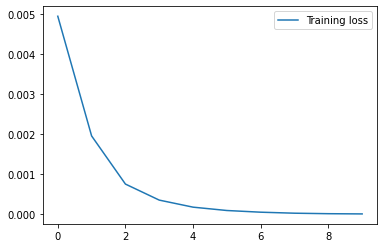

In [32]:
import matplotlib.pyplot as plt
#Plot the training and validation losses
plt.plot(train_losses, label="Training loss")
plt.legend()
plt.show()